# Tentative functions for NN

# Imports

In [1]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

#use another GPU if the default one is occupied
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey
from jax import lax

jax.config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

#use this line to set the device to be used for the computations
#print(jax.devices())
#DOES NOT RECOGNIZE THE OPTION NAME FTM
#jax.config.update('jax_default_device', jax.devices()[1])

import equinox as eqx

import haiku as hk

from functools import partial

In [4]:
from jax_md import space

In [5]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import CellState, SpaceFunc
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield, sec_nn
from chem_twotypes.divrates import S_set_divrate, div_nn

from chem_twotypes.initial_states import init_state_grow

In [6]:
import matplotlib.pyplot as plt

from tqdm import tqdm

# Set Parameters

In [7]:
ParamsDict = dict

In [8]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2




#which ctype secretes which chemical
#-------------------------------------------------------------------------------
### OLD MESSY VERION

#sec_by_ctype = {0:[1], 1:[2]} #two ctypes, each secreting one chem

#first half secreted by ct 1 and others by ct 2
#sec_ctype = [[ct] for ct in np.ones(n_chem, dtype=int).at[n_chem//2:].set(2).tolist()]
# sec_ctype[1] = [2]
# sec_ctype[3] = [1]

#assumes ctypes lists in index i correspond to ctypes secreting chemical i
#sec_by_ctypes = np.array(sec_ctype, dtype=int) #array or indexing will fail inside secdiff

#-------------------------------------------------------------------------------
### NEW CLEAN VERSION

#rows are ctypes, cols are chemicals
#1 if ct secretes chem, 0 otw
ctype_sec_chem = np.identity(n_chem, dtype=np.int16) #needs to be array for indexing


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.array([1.,1.])
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
sec_max = sec_max.at[0].set(20.)
sec_max = sec_max.at[1].set(2.)


sec_gamma = .5* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 1.*np.ones((n_chem,n_chem), dtype=np.float32) 


# # DIVISION

div_gamma = 2.*np.ones(n_chem, dtype=np.float32)
div_k = 1.*np.ones(n_chem, dtype=np.float32)
# div_k = div_k.at[0].set(3.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 3. #orange
eps_OneOne = 3. #blue
eps_OneTwo = 3. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for potential minimization
mech_relaxation_steps = 50


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 170
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

assert ncells_init > n_ones_init

In [9]:
#equinox automatically treats as static all non-array values
#cast floats/ints into arrays if the parameter needs a gradient

def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [10]:
train_params = {
    'n_chem': False,
    #'secreted_by_ctypes': False,
    'ctype_sec_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    
    'div_gamma' : False,
    'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : False,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [11]:
params = {
    'n_chem': n_chem,
    #'secreted_by_ctypes': sec_by_ctypes,
    'ctype_sec_chem': ctype_sec_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}



p, hp = eqx.partition(params, train_params)

# Simulation

In [12]:
key = PRNGKey(0)

## Generate initial state

In [13]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

## Generate init-apply functions

In [28]:
# init division nn
DIV_HIDDEN = 3

div_init, div_nn_apply = div_nn(params,train_params,DIV_HIDDEN,train=True)

params, train_params = div_init(istate, key)

In [29]:
#init secretion nn
SEC_HIDDEN = 5

sec_init, sec_nn_apply = sec_nn(params,train_params,SEC_HIDDEN,train=False)

params, train_params = sec_init(istate, key)

In [30]:
# functions in this list will be executed in the given order
# at each simulation step

fstep = [
    S_cell_division,
    partial(S_grow_cells, grate=.05),
    S_mechmin_twotypes,
    partial(S_ss_chemfield, sec_fn=sec_nn_apply),
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]


sim_init, sim_step = simulation(fstep, params, fspace)

# Optimization

In [31]:
from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from jax_morph.losses import reinforce_loss, avg_loss, simple_loss
from jax_morph.state_metrics import diff_n_ctypes

## Optimization loop

In [32]:
EPOCHS = 15
EPISODES_PER_UPDATE = 64 #32

LEARNING_RATE = .1


p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)


ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
params_t = [p]
loss_t = [float(l)]
rloss_t = [float(ll)]


#--------------------------------------------


for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    #estimate actual avg loss
    l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    #store
    loss_t.append(float(l))
    rloss_t.append(float(ll))
    params_t.append(p)
    

100%|████████████████████████████████████████████████| 15/15 [02:28<00:00,  9.87s/it]


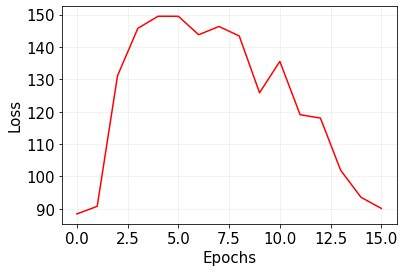

In [33]:
#plt.hlines(AVG_EQ_PARAMS, 0, EPOCHS, colors='k', linestyles='--')
#plt.axhspan(ymin=AVG_EQ_PARAMS-STD_EQ_PARAMS, ymax=AVG_EQ_PARAMS-STD_EQ_PARAMS, fc='k')

plt.plot(np.sqrt(np.array(loss_t)), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)


plt.xlabel('Epochs')
plt.ylabel('Loss');

## Initial params

In [34]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=200, key=subkey)

0.81904763


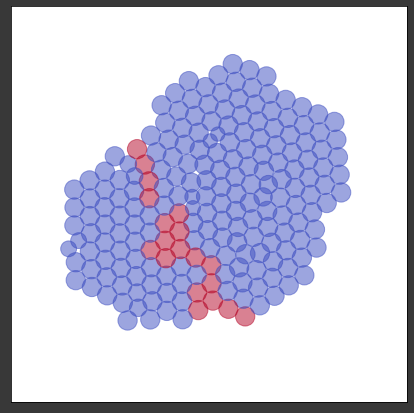

In [35]:
draw_circles_ctype(fstate);

print(diff_n_ctypes(fstate, relative=True))

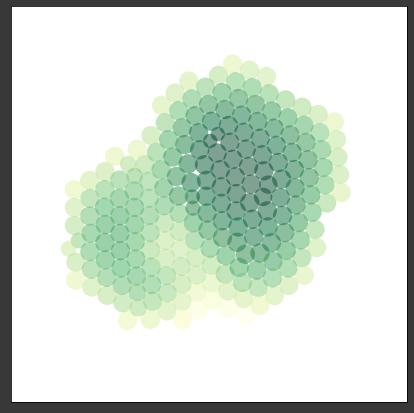

In [36]:
draw_circles_chem(fstate);

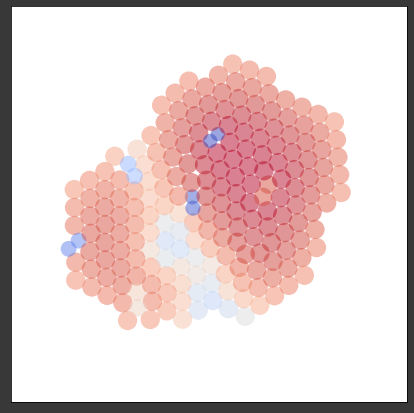

In [37]:
draw_circles_divrate(fstate);

## Trained params

In [38]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=200, key=subkey)

-0.14285715


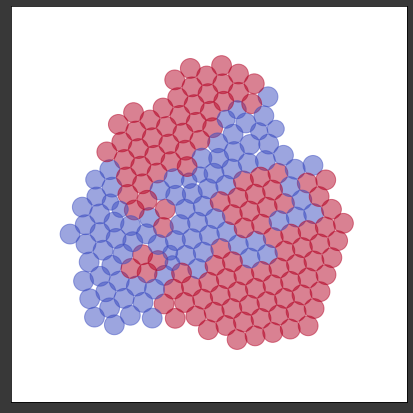

In [39]:
draw_circles_ctype(fstate);

print(diff_n_ctypes(fstate, relative=True))

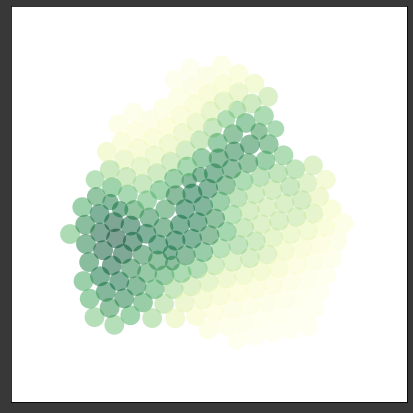

In [40]:
draw_circles_chem(fstate);

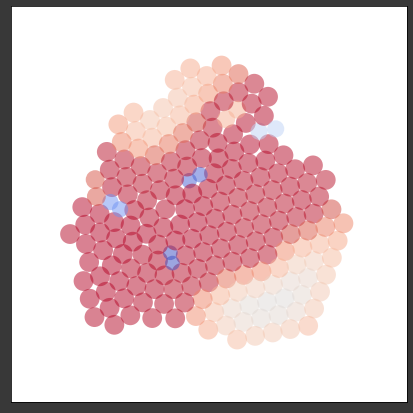

In [41]:
draw_circles_divrate(fstate);

## Different hidden sizes

In [171]:
#@eqx.filter_jit
def optimize(params,
             train_params,
             istate,
             key,
             EPOCHS = 30,
             EPISODES_PER_UPDATE = 128, #32
             LEARNING_RATE = .1,
             DIV_N = 5,
        ):

    key, subkey = split(key)

    div_init, div_nn_apply = div_nn(params,train_params,DIV_N)

    params, train_params = div_init(istate, subkey)

    fstep = [
        S_cell_division,
        partial(S_grow_cells, grate=.05),
        S_mechmin_twotypes,
        S_ss_chemfield,
        partial(S_set_divrate, divrate_fn=div_nn_apply)
    ]


    sim_init, sim_step = simulation(fstep, params, fspace)


    p, hp = eqx.partition(params, train_params)

    # init optimizer
    optimizer = optax.adam(LEARNING_RATE)
    opt_state = optimizer.init(p)


    #--------------------------------------------
    #store loss at initial params and calc grad 

    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)


    ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    #store initial params and loss
    #params_t = [p]
    #loss_t = [float(l)]
    #rloss_t = [float(ll)]


    #--------------------------------------------

    loss_t = np.zeros(EPOCHS+1)
    loss_t = loss_t.at[0].set(l)

    for t in tqdm(np.arange(EPOCHS), total=EPOCHS):

        #generate batch of random keys
        key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
        batch_subkeys = np.array(batch_subkeys)

        # sgd step
        updates, opt_state = optimizer.update(grads, opt_state, p)

        p = eqx.apply_updates(p, updates)

        # surrogate loss and grads
        ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

        #estimate actual avg loss
        l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

        #store
        #loss_t.append(float(l))
        #rloss_t.append(float(ll))
        #params_t.append(p)
        loss_t = loss_t.at[t+1].set(l)
    
    return np.sqrt(loss_t), p

In [ ]:
div_ns = [5,10,15,20]

loss_n = {}
pp_n = {}

for DIV_N in div_ns:
    
    print(f'Training with {DIV_N} neurons...')
    
    key, subkey = split(key)

    lt,pp = optimize(params, train_params, istate, subkey, 15, DIV_N=DIV_N)
    
    loss_n[DIV_N] = lt.tolist()
    pp_n[DIV_N] = pp

Training with 5 neurons...


100%|████████████████████████████████████████████████| 15/15 [01:09<00:00,  4.62s/it]


Training with 10 neurons...


100%|████████████████████████████████████████████████| 15/15 [01:10<00:00,  4.72s/it]


Training with 15 neurons...


100%|████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.74s/it]


Training with 20 neurons...


 67%|████████████████████████████████                | 10/15 [00:47<00:23,  4.70s/it]

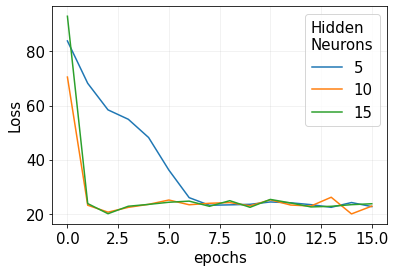

In [177]:
for n in loss_n:
    plt.plot(loss_n[n], label=str(n))
    
    
plt.xlabel('epochs')
plt.ylabel('Loss')

    
plt.grid(alpha=.2)
plt.legend(title='Hidden\nNeurons');

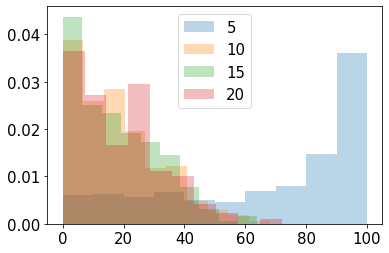

In [50]:
p, hp = eqx.partition(params, train_params)


for n in pp_n:
    
    key, subkey = split(key)

    div_init, div_nn = div_nn_chem(params,train_params,n)

    params, train_params = div_init(istate, subkey)
    
    ppp, hpp = eqx.partition(params, train_params)
    
    key, *subkeys = split(key, 301)
    subkeys = np.array(subkeys)

    lss = simple_loss(ppp, hpp, fstep, fspace, istate, subkeys)

    plt.hist(np.sqrt(lss).tolist(), alpha=.3, label=str(n), density=True)
    
    
plt.legend();

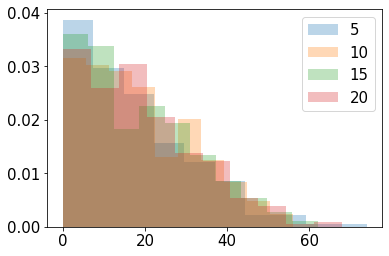

In [49]:
p, hp = eqx.partition(params, train_params)


for n in pp_n:
    
    key, *subkeys = split(key, 301)
    subkeys = np.array(subkeys)

    lss = simple_loss(pp_n[n], hp, fstep, fspace, istate, subkeys)

    plt.hist(np.sqrt(lss).tolist(), alpha=.3, label=str(n), density=True)
    
    
plt.legend();